# WFSI Pilot Demo

## Setup

Import python libraries

In [1]:
from IPython.display import display

import csv
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import shutil
import tempfile
import xarray as xr
import xarray.plot as xplt
import xml.etree.ElementTree as ET

import urllib.request
from urllib.request import Request, urlopen

### Configure WFSI pilot repository access

Set access to WFSI Pilot Repository (https://portal.wfsi-data.lbl.gov/data).
This notebook only works for publically available datasets.

In [2]:
repo_url = 'https://portal.wfsi-data.lbl.gov/catalog/d1/mn/v2/object/'

# Get files from repo or use local files already acquired
use_local_files = False

### Configure local directories

In [3]:
# configure a base directory, if left blank, the current working directory will be used.
base_dir = None

if not base_dir:
    base_dir = os.getcwd()

# if you would like to store the (meta)data files used, configure the local storage directory path. Otherwise leave as None.
# local_storage = None
local_storage = os.path.join(base_dir, 'data')

# ---------------------------------------------------------------------------
remove_data_files = False

if not local_storage:
    temp_dir = tempfile.mkdtemp()
    local_storage = os.path.join(base_dir, temp_dir)
    remove_data_files = True
    
if os.path.exists(local_storage):
    print(f'Data downloaded will be stored in {local_storage}')
else:
    print(f'Specified storage directory {local_storage} does not exist. Create it before continuing!')

Data downloaded will be stored in <current_working_dir>


### Load functions

In [4]:
def retrieve_dataset_file(file_name, lookup, local_path=local_storage, repo_base_url=repo_url, local=use_local_files):
    """ Retrieve a dataset file using the filename """
    local_file_path = os.path.join(local_path, file_name)
    uuid = lookup.get(file_name)
    
    if local:
        if not uuid:
            print(f'No uuid found for file: {file_name}')
        return local_file_path
    elif not uuid:
        print(f'No uuid found for file: {file_name}')
        return False
    
    result, msg = retrieve_file_from_repo(uuid, local_file_path, repo_base_url)
    
    if not result:
        print(msg)
        return False
    
    file_path = os.path.join(local_path, file_name)
    
    if os.path.exists(file_path):
        return file_path
    
    return False
    
def retrieve_file_from_repo(url_uuid, file_path, repo_base_url=repo_url):
    """ Retrieve the data file 
        file_path includes file name.
    """
    
    file_url = url_uuid
    if repo_base_url:
        file_url = f'{repo_base_url}{url_uuid}'
        
    try:
        urllib.request.urlretrieve(file_url, file_path)
        return True, None
    except Exception as e:
        return False, f'File at url: {file_url} was not saved: {e}'
    
def parse_xml_file(file_path, prefix='urn-uuid-', replacement_prefix='urn:uuid:'):
    """ Parse the xml file to create a lookup of filename and uuid """
    lookup = {}
    
    with open(file_path, 'r') as f:
        tree = ET.parse(f)
    
    root = tree.getroot()
    
    count = 0
    for element in root.findall('dataset/otherEntity'):
        
        value = element.get('id')
        if prefix and value.startswith(prefix):
            value = value.replace(prefix, replacement_prefix)
        
        key = None
        name_element = element.find('entityName')
        
        if isinstance(name_element, ET.Element):
            key = name_element.text
        if key and value and isinstance(key, str) and isinstance(value, str):
            lookup.update({key: value})
            count += 1
        else:
            element_id = element.get('id')
            print(f'{element.tag} with id: {element_id} could not be parsed.')
            
    print(f'{count} files successfully added to the lookup.')
    
    return lookup
        
def calc_speed(uvw):
    """ Calculate 3D speed """
    if any(i is np.nan for i in uvw):
        return np.nan
    return math.sqrt(uvw[0]**2 + uvw[1]**2 + uvw[2]**2)

def calc_horiz_speed(uvw):
    """ Calculate speed in x-y plane. """
    if any(i is np.nan for i in uvw[0:1]):
        return np.nan
    return math.sqrt(uvw[0]**2 + uvw[1]**2)

def calc_horiz_bearing(uvw):
    """ Calculate bearing in x-y plane; 
        North = 0 deg, positive clockwise so that east = 90 deg, west = 270 deg """
    if any(i is np.nan for i in uvw[0:1]):
        return np.nan
    ang_rad = math.atan2(uvw[0], uvw[1])  # atan2(y, x), returns atan(y / x)
    ang_deg = ang_rad * 180 / math.pi
    if ang_deg < 0:
        return ang_deg + 360
    return ang_deg

def calc_vert_direction(uvw):
    """ Calculate vertical direction: 1 = up; 0 = none; -1 down """
    w = uvw[2]
    if w is np.nan:
        return np.nan
    elif w == 0:
        return 0
    elif w > 0:
        return 1
    else:
        return -1
    
def calc_vert_speed(uvw):
    if uvw[2] is np.nan:
        return np.nan
    return abs(uvw[2])

def make_dict_element(keys: list, values: list) -> dict:
    """ Helper function to make dict elements """
    if len(keys) != len(values):
        print('keys and values input lists are not the same length. Fail.')
        return {}
    dict_element = {}
    for k, v in zip(keys, values):
        if v:
            dict_element[k] = v
    return dict_element

def read_csv_to_dict(filepath: str, encoding: str = 'utf-8', use_idx_key: bool = True, print_header: bool = True) -> dict:
    """ Read a csv and convert it to a dictionary """
    csv_dict = {}
    
    with open(filepath, 'r', encoding=encoding) as f:
        csv_file = csv.reader(f)
        for idx, row in enumerate(csv_file):
            if idx == 0:
                header = row
                if print_header:
                    print(f'File header: {header}')
                continue
            if use_idx_key:
                csv_dict.update({idx: make_dict_element(header, row)})
                continue
            csv_dict.update({row[0]: make_dict_element(header, row)})
    
    return header, csv_dict

def gen_stats(dataset, var, dim_coord, max_threshold=10, error_code_var='error_code'):
    """ Generate stats for a given variable in a xarray Dataset; return in a pandas DataFrame """
    data_array = dataset[var]
    
    max_val = data_array.max(dim=dim_coord)
    max_val_time = data_array.idxmax(dim=dim_coord)

    min_val = data_array.min(dim=dim_coord)
    min_val_time = data_array.idxmin(dim=dim_coord)

    missing_vals = data_array.isnull().sum(dim=dim_coord)
    error_codes = dataset[error_code_var]
    error_codes = error_codes.where(error_codes > 0).count(dim=dim_coord)
    
    threshold = data_array.where(data_array > max_threshold).count(dim=dim_coord)
    
    raw_stats = pd.DataFrame({'Sensor': max_val.id,
                              f'max_{var}': max_val.to_series(), f'time_max_{var}': max_val_time.to_series(),
                              f'{var}_count_over_{max_threshold}': threshold.to_series(),
                              f'min_{var}': min_val.to_series(), f'time_min_{var}': min_val_time.to_series(),
                              f'{var}_nan': missing_vals, f'{var}_errors': error_codes})
    return raw_stats


def get_id_indices(ds, sensors):
    """ Convert ids to indices """
    ids = ds.id.to_series()

    if not sensors:
        return range(0, ids.shape[0])
    else:
        return ids[ids.isin(sensors)].index.to_list()

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

## Load data package xml file

From the dataset page on the repository, copy the unique identifier (uuid) under General > Identifier.

Paste the uuid into the xml_uuid variable below.

In [5]:
# Set uuid (from dataset General Identifier)
xml_uuid = 'urn:uuid:d2526b51-7d03-43df-8cf1-e2dd03ae0bad'

xml_file_path = os.path.join(local_storage, 'dataset_metadata.xml')

In [6]:
result, msg = retrieve_file_from_repo(xml_uuid, xml_file_path)

if not msg:
    print('Success - metadata xml downloaded.')
else:
    print(msg)

Success - metadata xml downloaded.


Parse the xml file to create a lookup for the repository uuid codes for each data file in the dataset.

In [7]:
xml_lookup = parse_xml_file(xml_file_path)

if not xml_lookup:
    print(f'Problem parsing xml_file: {xml_file}')

86 files successfully added to the lookup.


In [8]:
# Inspect xml_lookup if desired
for k, v in xml_lookup.items():
    display(f'{k} -- {v}')

'supplementary_data_81000V_90L.pdf -- urn:uuid:88afcf5c-e98f-4598-a7b3-48de5c294856'

'supplementary_data_visualizations_locations_Burn01_Plot.html -- urn:uuid:85bf6d8b-3ed4-4bec-9341-69a56d752784'

'metadata_locations_Plot_dd.csv -- urn:uuid:10ebdbae-0b59-4937-8c68-496fe5015bef'

'data_Sonic_dd.csv -- urn:uuid:99c06523-7461-471c-8fda-d21f27ed75b3'

'supplementary_data_Sonic_Error.csv -- urn:uuid:5c1ca05f-7d75-4c0b-bf10-a9c94b7a4327'

'supplementary_data_Sonic_Error_dd.csv -- urn:uuid:c9e9c322-efab-41c1-bf60-2a306ab23fdb'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_A2_DIAG.html -- urn:uuid:6d0e942b-5a38-4dc9-a9fd-608c515d0e5d'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_A3_DIAG.html -- urn:uuid:3c6ca6a9-deae-4102-a531-a8d0d75acf0e'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_A4_DIAG.html -- urn:uuid:3fc21317-ca7c-4151-814f-a22242c68fd0'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_B1_DIAG.html -- urn:uuid:766f4f0c-0bde-4624-bfbb-298b979192ff'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_B2_DIAG.html -- urn:uuid:6d64a90b-fb5d-4020-8c56-e2c1d01aff47'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_B3_DIAG.html -- urn:uuid:b8f32052-cd84-445d-91b8-5fbb11b462a2'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_B4_DIAG.html -- urn:uuid:a055d6d0-b4c6-47cb-8122-403012792db9'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_C1_DIAG.html -- urn:uuid:38b65b1b-965e-4018-8512-be1f090a9cf6'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_C2_DIAG.html -- urn:uuid:78faedb2-1a40-4fe9-aeb0-263dea0a8d18'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_C3_DIAG.html -- urn:uuid:5e0411a9-fee0-44de-bd9b-670addc4d648'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_C4_DIAG.html -- urn:uuid:ea345674-2e33-4d5f-a5d9-a5f1eb748849'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_CT_DIAG.html -- urn:uuid:e0560dae-ef90-4750-8d9d-1d96d72a981f'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_D1_DIAG.html -- urn:uuid:347ecda6-f142-41c8-8321-e7028838049c'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_D2_DIAG.html -- urn:uuid:8d713929-674d-4472-ac7d-78bc74e53306'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_D3_DIAG.html -- urn:uuid:31b0214c-f3d1-43e9-aa00-776d7a34e788'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_D4_DIAG.html -- urn:uuid:be2af7ff-fe49-4fa0-aa3f-35f7cc53b8da'

'supplementary_data_visualizations_Sonic_Graphs_Burn01_Sonic_Graphs_Burn01_Sonic_A1_DIAG.html -- urn:uuid:8249716e-6357-4bed-8756-43e3128f2af4'

'data_Burn01_Sonic_Burn01_Sonic_D4.csv -- urn:uuid:a635214a-606e-4f36-a992-5e2c503ff485'

'data_Burn01_Sonic_Burn01_Sonic_D3.csv -- urn:uuid:9109b33d-b9f2-4188-83eb-c7de7acf16c6'

'data_Burn01_Sonic_Burn01_Sonic_D2.csv -- urn:uuid:2aedd887-b129-4c43-9f5f-d4bbe0611e2b'

'data_Burn01_Sonic_Burn01_Sonic_D1.csv -- urn:uuid:51e36efc-d4d4-4c99-bb48-9521c4002dee'

'data_Burn01_Sonic_Burn01_Sonic_CT.csv -- urn:uuid:089b9b3c-94a6-4ae5-ba18-600d0c16b9eb'

'data_Burn01_Sonic_Burn01_Sonic_C4.csv -- urn:uuid:81a8b372-a605-463a-bbfb-c8a4ea8da68e'

'data_Burn01_Sonic_Burn01_Sonic_C3.csv -- urn:uuid:d9b42eec-e305-4e3f-865f-4d7cfe63d1ad'

'data_Burn01_Sonic_Burn01_Sonic_C2.csv -- urn:uuid:8514b3cb-a8be-42be-830b-64d139a86ed7'

'data_Burn01_Sonic_Burn01_Sonic_C1.csv -- urn:uuid:eefc4058-63a5-4fde-a556-f0dcdb5d6bd1'

'data_Burn01_Sonic_Burn01_Sonic_B4.csv -- urn:uuid:bade4377-7f25-4e43-ba79-54aa68dfe8ab'

'data_Burn01_Sonic_Burn01_Sonic_B3.csv -- urn:uuid:b6ea193d-ddc0-42e8-8350-d0b1a75129a5'

'data_Burn01_Sonic_Burn01_Sonic_B2.csv -- urn:uuid:fb6cff21-8524-495b-b8fa-4dff30c9d909'

'data_Burn01_Sonic_Burn01_Sonic_B1.csv -- urn:uuid:17941039-f266-4747-a891-0c951c9e0f3d'

'data_Burn01_Sonic_Burn01_Sonic_A4.csv -- urn:uuid:90d16f17-fe84-4564-8452-255a253a4f77'

'data_Burn01_Sonic_Burn01_Sonic_A3.csv -- urn:uuid:8b41c9bc-46ef-47c8-8336-2ad7c80a6713'

'data_Burn01_Sonic_Burn01_Sonic_A2.csv -- urn:uuid:c8c78e54-57bd-4581-876d-d8eaca16d229'

'data_Burn01_Sonic_Burn01_Sonic_A1.csv -- urn:uuid:875abae7-b108-4d95-83da-408146b417eb'

'metadata_ProjectDescription.pdf -- urn:uuid:e8e23be2-5e46-43b9-ad37-a53ef79f773a'

'metadata_Locations.png -- urn:uuid:7ffadad7-ae2c-4d1c-b683-6cc6c16b7388'

'metadata_DataDescription.pdf -- urn:uuid:838036d1-60fa-4ddc-8220-633742b4b2e7'

'metadata_BurnSummary.csv -- urn:uuid:f2ebb726-7522-49ce-b7e9-c1b2d712c6ed'

'metadata_BurnSummary_ref_IGN_SIDE_CD.csv -- urn:uuid:2c46c4da-4e88-4ed1-92bb-b78f5d38fbad'

'metadata_BurnSummary_ref_FUEL_DISP_CD.csv -- urn:uuid:f51a1cdd-7508-4940-bc26-0bce5b3f7914'

'metadata_BurnSummary_ref_FUEL_CD.csv -- urn:uuid:dcd28819-f3c6-4275-ac57-d5193390b916'

'metadata_BurnSummary_ref_FS_CD.csv -- urn:uuid:536aae33-75a9-42cd-9b79-d9d36dc04e7c'

'metadata_BurnSummary_ref_dd.csv -- urn:uuid:c6fe5a2b-5314-4be9-9309-e14fbecace03'

'metadata_BurnSummary_dd.csv -- urn:uuid:2725e5c4-695d-4e62-9f64-d3bb44e26a97'

'flmd.csv -- urn:uuid:04e2955d-b176-41d5-9e24-781201b961d6'

'metadata_locations_Burn12_Plot.csv -- urn:uuid:46361e65-7239-4d8b-8bac-30e65f530e2f'

'metadata_locations_Burn10_Plot.csv -- urn:uuid:73388c6f-c3da-4d19-8c23-e22358e2f6e2'

'metadata_locations_Burn09_Plot.csv -- urn:uuid:0ec837d0-a8f5-4644-bd6c-86a75c72a2ac'

'metadata_locations_Burn17_Plot.csv -- urn:uuid:fcced110-e5e1-41f4-8a35-389bcbc01a9d'

'metadata_locations_Burn15_Plot.csv -- urn:uuid:ce3bb5aa-9996-4b6d-8e04-984fbd8f5e8c'

'metadata_locations_Burn14_Plot.csv -- urn:uuid:db7f8618-2b52-4876-8823-d2cc2a1e788b'

'metadata_locations_Burn31_Plot.csv -- urn:uuid:ce859e8d-6b1c-41e1-a1ce-b0ace91c8f51'

'metadata_locations_Burn02_Plot.csv -- urn:uuid:71be742a-2af2-47ab-8209-f8234f023e91'

'metadata_locations_Burn01_Plot.csv -- urn:uuid:2dd9eab0-906b-44a9-b68a-5f461cf01e84'

'metadata_locations_Burn13_Plot.csv -- urn:uuid:b8c27dc3-1b8e-43ec-9eaa-a50321657b00'

'metadata_locations_Burn11_Plot.csv -- urn:uuid:4678b49c-1dec-41aa-a713-19e41b57c6e6'

'metadata_locations_Burn08_Plot.csv -- urn:uuid:cbdac490-35f2-4fe4-b3a5-214f3c67ff17'

'metadata_locations_Burn07_Plot.csv -- urn:uuid:291f0add-69cc-4d26-b450-755d532f9ba8'

'metadata_locations_Burn06_Plot.csv -- urn:uuid:02f8fd04-fa2d-42ca-8e37-0d2371322c1c'

'metadata_locations_Burn05_Plot.csv -- urn:uuid:2ecbe241-b1bc-4ad5-909b-dcb9dd416f98'

'metadata_locations_Burn04_Plot.csv -- urn:uuid:08609cb6-cc5d-4817-96b9-d6f2bfcf570f'

'metadata_locations_Burn03_Plot.csv -- urn:uuid:a4a9f74b-85d7-438e-974f-77446f0504a5'

'metadata_locations_Burn28_Plot.csv -- urn:uuid:1e64dd37-6b6f-4915-ac8b-16402e5e5781'

'metadata_locations_Burn27_Plot.csv -- urn:uuid:1a207772-4cff-4e15-a7fb-456586556420'

'metadata_locations_Burn26_Plot.csv -- urn:uuid:3ba88e7f-52aa-4663-87ec-8c0531e10688'

'metadata_locations_Burn25_Plot.csv -- urn:uuid:d0b9f3bd-222b-42ae-a06d-e8fc12fc839f'

'metadata_locations_Burn24_Plot.csv -- urn:uuid:7e8daa36-66be-4d41-94c3-85567c24fa17'

'metadata_locations_Burn23_Plot.csv -- urn:uuid:de149ef9-4388-4908-9e4c-77de613dd3b0'

'metadata_locations_Burn22_Plot.csv -- urn:uuid:e8fb3d52-1052-4e5b-9f3e-555605568b6a'

'metadata_locations_Burn21_Plot.csv -- urn:uuid:fbf10809-8504-4b2c-99bf-3897c4841e5e'

'metadata_locations_Burn20_Plot.csv -- urn:uuid:67f0d298-11e9-42c8-8b12-e9bdbf2b9539'

'metadata_locations_Burn19_Plot.csv -- urn:uuid:af632cf0-376a-4aa1-b21b-5083b89d9103'

'metadata_locations_Burn18_Plot.csv -- urn:uuid:95be72fb-bffc-4cc4-bee1-6821f139abe8'

'metadata_locations_Burn16_Plot.csv -- urn:uuid:4a7bd8e9-969a-4b3f-b750-87d68500b0a9'

'metadata_locations_Burn35_Plot.csv -- urn:uuid:c0d19bb6-7a3e-4a95-a98d-a0fe21254b0e'

'metadata_locations_Burn34_Plot.csv -- urn:uuid:43829697-01c4-4b46-b702-321edd2f4f75'

'metadata_locations_Burn33_Plot.csv -- urn:uuid:7ba7f13e-a07b-4bc6-ab8b-6ea493c7312e'

'metadata_locations_Burn32_Plot.csv -- urn:uuid:1c5b2068-3a53-49af-9f59-d225f68c79d4'

'metadata_locations_Burn30_Plot.csv -- urn:uuid:33a4868f-6a3a-4aa9-9da5-d6e360c4f429'

'metadata_locations_Burn29_Plot.csv -- urn:uuid:63d860fc-bd3d-4acf-91c6-754e622b0d21'

## Data package navigation info

Load and view file-level metadata description (flmd).

In [9]:
flmd_path = retrieve_dataset_file('flmd.csv', xml_lookup)
flmd_header, flmd = read_csv_to_dict(flmd_path)

File header: ['File_Name', 'File_Description', 'Standard', 'UTC_Offset', 'File_Version', 'Contact', 'Start_Date', 'End_Date', 'Northwest_Latitude_Coordinate', 'Northwest_Longitude_Coordinate', 'Southeast_Latitude_Coordinate', 'Southeast_Longitude_Coordinate', 'Latitude', 'Longitude', 'Missing_Value_Codes', 'Notes', 'Field_Name_Orientation']


### View file info: select metadata, data, supplementary_data

In [10]:
info_type = 'all'  # enter all, metadata, data, supplementary_data

for file_idx, file_info in flmd.items():
    if info_type != 'all' and not file_info[flmd_header[0]].startswith(info_type):
        continue
    display(f'Index {file_idx}: {file_info[flmd_header[0]]} - {file_info[flmd_header[1]]}')

'Index 1: metadata_ProjectDescription.pdf - Description of project'

'Index 2: metadata_DataDescription.pdf - Description of sonic data'

'Index 3: metadata_Locations.png - Idealized rendering of equipment locations for 10 x 10m field experiments.'

'Index 4: metadata_BurnSummary.csv - General parameters of each burn experiment'

'Index 5: metadata_BurnSummary_dd.csv - Data Dictionary for BurnSummary.csv'

'Index 6: metadata_BurnSummary_ref_dd.csv - Data Dictionary for BurnSummary_ref-*.csv'

'Index 7: metadata_BurnSummary_ref-*.csv - Explanation of coded vocabularies used in the BurnSummary.csv data'

'Index 8: metadata_locations_Burn*_Plot.csv - coordinates to identify the specific location (X,Y,Z) of each sensor and important items including plot corners, center tower and trees within the plot'

'Index 9: metadata_locations_Plot_dd.csv - Data Dictionary for Burn*_Plot.csv files'

'Index 10: data_Sonic_dd.csv - Data Dictionary for /Burn*/Sonic*(_*).csv data files'

'Index 11: data_Burn*_Sonic_Burn*_Sonic*(_*).csv - Raw sonic data per burn, 10 Hz'

'Index 12: supplementary_data_visualizations_data_Burn*_Plot*_Sonic*(_*).html - html visualization of the raw sonic data per bern per sonic sensor'

'Index 13: supplementary_data_visualizations_locations_Burn*_Plot.html - htm visualization of the locations of plot features'

'Index 14: supplementary_data_Sonic_Error.csv - The percentage of missing data (NaN) and data with suspect diagnostic codes burns per burn per sonic'

'Index 15: supplementary_data_Sonic_Error_dd.csv - Data Dictionary for supplementary_data/Sonic_Error.csv file'

'Index 16: supplementary_data_81000V-90L.pdf - RM Young sonic manual'

In [11]:
# View file-level metadata for specified data package element
display(flmd[8])

{'File_Name': 'metadata_locations_Burn*_Plot.csv',
 'File_Description': 'coordinates to identify the specific location (X,Y,Z) of each sensor and important items including plot corners, center tower and trees within the plot',
 'Contact': 'Nicholas Skowronski',
 'Northwest_Latitude_Coordinate': '39.91825',
 'Northwest_Longitude_Coordinate': '-74.59796',
 'Southeast_Latitude_Coordinate': '39.91591',
 'Southeast_Longitude_Coordinate': '-74.59502',
 'Latitude': '39.91774',
 'Longitude': '-74.596422',
 'Missing_Value_Codes': 'NaN',
 'Field_Name_Orientation': 'horizontal'}

-------------------------------------------------------------------------------------

## Select Burn

Have a look at the burn summary. First load the file.

In [12]:
burn_summary_path = retrieve_dataset_file('metadata_BurnSummary.csv', xml_lookup)
bs_header, burn_summary = read_csv_to_dict(burn_summary_path, use_idx_key=False)

File header: ['BURN', 'CAMPAIGN', 'BURN_GRP', 'PLOT_NUM', 'DATE', 'BTZ_START', 'BTZ_END', 'AT_START', 'BT_START', 'AT_END', 'COMPLETE', 'FS_CD', 'AMB_TEMP', 'RH', 'WIND_SPEED', 'MAX_WIND', 'WIND_DIR', 'FUEL_CD', 'FUEL_LOAD', 'FC_CD', 'FUEL_HGT', 'IGN_SIDE_CD', 'NOTES', 'REVIEW_COMMENTS']


Inspect some of the burns.

**CONSIDER**: good place to incorporate data dictionaries to extract units and match up controlled vocab.

In [13]:
burn_list = [1, 2, 19, 88]

for burn_no in burn_list:
    burn_info = burn_summary.get(str(burn_no))
    if not burn_info:
        print(f'Did not find burn {burn_no}')
        continue
    display(f'{burn_no}: {burn_info["DATE"]} - Temp: {burn_info["AMB_TEMP"]} - RH: {burn_info["RH"]}')

'1: 3/5/2018 - Temp: 5.4 - RH: 43.3'

'2: 3/6/2018 - Temp: 6.5 - RH: 42.8'

'19: 9/22/2018 - Temp: 19.2 - RH: 61.6'

Did not find burn 88


**---- Select Burn ----**

In [14]:
burn_id = '01'

print(f'Burn {burn_id} selected for the analyses below.')

Burn 01 selected for the analyses below.


-------------------------------------------------------------------------------------

## Plot sensor locations and heights

In [15]:
# import locations dd file
locations_dd_path = retrieve_dataset_file('metadata_locations_Plot_dd.csv', xml_lookup)
dd_headers, locations_dd = read_csv_to_dict(locations_dd_path)

File header: ['Column_or_Row_Name', 'Unit', 'Definition', 'Column_or_Row_Long_Name', 'Data_Type']


In [16]:
# print dd info if needed
for loc_dd in locations_dd.values():
    display(f'{loc_dd.get(dd_headers[0])} - Unit: {loc_dd.get(dd_headers[1])} - Definition: {loc_dd.get(dd_headers[2])}')

'LABEL - Unit: None - Definition: Item label.'

'ITEM - Unit: None - Definition: Item type.'

'PLATFORM_TYPE - Unit: None - Definition: Platform type where the item was located (Center Tower, Ground and Truss).'

'PLATFORM - Unit: None - Definition: The platform where the item located.'

'LOC - Unit: None - Definition: The location on the platform.'

'SUBLOC - Unit: None - Definition: The sublocation within the location on the platform.'

'X - Unit: m - Definition: X coordinate (meters) in local coordinate system.'

'Y - Unit: m - Definition: Y coordinate (meters) in local coordinate system.'

'Z - Unit: m - Definition: Height above the ground (meters).'

'NOTES - Unit: None - Definition: Notes.'

In [17]:
# import locations for specified burn
locations_path = retrieve_dataset_file(f'metadata_locations_Burn{burn_id}_Plot.csv', xml_lookup)
burn_locs = pd.read_csv(locations_path)

unique_item_types = set()
for i in burn_locs.loc[:, 'ITEM']:
    unique_item_types.add(i)
print(f'Items in plot locations: {unique_item_types}')

Items in plot locations: {'Center Tower', 'Pressure Sensor', 'Plot Corner', 'Sonic', 'Tree', 'IR Camera', 'Thermocouple', 'Krem Box'}


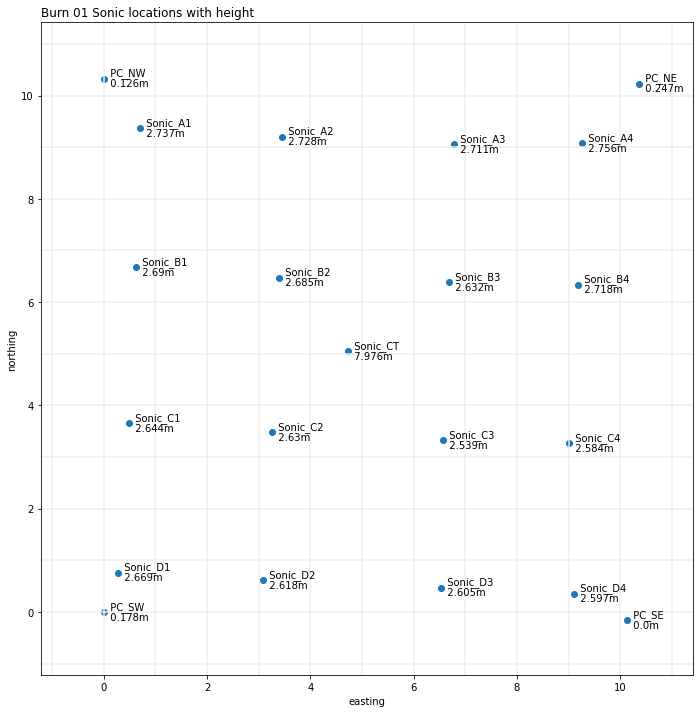

In [18]:
# set location headers - depending on dataset
loc_headers = ('X', 'Y', 'Z', 'LABEL')

# subset just the x, y, z locations and labels
item_types = ['Plot Corner', 'Sonic']
sonic_plot_locs = np.array(burn_locs.query(f'ITEM in {item_types}').loc[:, loc_headers])

# configure info for the axes
x_min_max = [sonic_plot_locs[:, 0].min(), sonic_plot_locs[:, 0].max()]
y_min_max = [sonic_plot_locs[:, 1].min(), sonic_plot_locs[:, 1].max()]
buffer = 0.1 * (max((x_min_max[1], y_min_max[1])) - min((x_min_max[0], y_min_max[0])))
min_max = [min((x_min_max[0], y_min_max[0])) - buffer, max((x_min_max[1], y_min_max[1])) + buffer]

# plot the locations
loc_fig, loc_axs = plt.subplots(figsize=(15, 12))
loc_axs.set_aspect('equal')
loc_axs.set_xlim(min_max); loc_axs.set_ylim(min_max)
for i in range(math.trunc(min_max[0]), math.trunc(min_max[1]) + 1):
    plt.axhline(y=i, color='#eeeeee')
    plt.axvline(x=i, color='#eeeeee')
loc_axs.scatter(sonic_plot_locs[:, 0], sonic_plot_locs[:, 1], marker='o')
for loc_set in sonic_plot_locs:
    loc_axs.text(loc_set[0], loc_set[1], f'  {loc_set[3]}', {'ha': 'left', 'va': 'bottom'})
    loc_axs.text(loc_set[0], loc_set[1], f'  {loc_set[2]}m', {'ha': 'left', 'va': 'top'})
loc_axs.set_ylabel('northing')
loc_axs.set_xlabel('easting')
loc_axs.set_title(f'Burn {burn_id} Sonic locations with height', loc='left')
plt.show()

## Select Sonic Sensors

In [19]:
sonic_sensor_ids = []

for fn in xml_lookup.keys():
    if fn.endswith('_Sonic_Control.csv') and f'data_Burn{burn_id}_Sonic' in fn:
        sonic_sensor_ids.append('Control')

# sensors installed
for loc_set in sonic_plot_locs:
    if loc_set[3].startswith('Sonic'):
        sonic_sensor_ids.append('_'.join(loc_set[3].split('_')[1:]))
                   
print(f'Burn {burn_id} sonic sensor ids installed: {sonic_sensor_ids}')

Burn 01 sonic sensor ids installed: ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'CT', 'D1', 'D2', 'D3', 'D4']


In [20]:
sonic_sensors = []  # if all, leave list empty
exclude_sensors = []  # Add sensor identifiers to exclude

if not sonic_sensors:
    sonic_sensors = sonic_sensor_ids
    
for sensor_id in exclude_sensors:
    sonic_sensors.pop(sensor_id)
    
print(f'Selected sensors: {sonic_sensors}')

Selected sensors: ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'CT', 'D1', 'D2', 'D3', 'D4']


-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------


## Combine raw data
Read in the individual sensor files and build a xarray.Dataset

In [21]:
# Look at data column headers
data_dd_path = retrieve_dataset_file('data_Sonic_dd.csv', xml_lookup)
dd_headers, data_dd = read_csv_to_dict(data_dd_path)

File header: ['Column_or_Row_Name', 'Unit', 'Definition', 'Column_or_Row_Long_Name', 'Data_Type']


In [22]:
# print dd info if needed
for dd in data_dd.values():
    display(f'{dd.get(dd_headers[0])} - Unit: {dd.get(dd_headers[1])} - Definition: {dd.get(dd_headers[2])}')

'TIMESTAMP - Unit: yyyy-MM-dd hh:mm:ss.0 - Definition: Local (EST) time adjusted for daylight savings. Note in Excel, set the specified format (yyyy-MM-dd hh:mm:ss.0) using the custom category to view the data correctly.'

'RECORD - Unit: None - Definition: None'

'U - Unit: m/s - Definition: Positive values of x (+) indicate wind from the east, negative values (-) indicate wind from the west. (Multiply U by -1 to convert positive U values to indicate wind from the west and negative U values indicating wind from the east).'

'V - Unit: m/s - Definition: Positive values of y (+) indicate wind from the north, negative values (-) indicate wind from the south. (Multiply V by -1 to convert positive V values to indicate wind from the south and negative U values indicating wind from the north).'

'W - Unit: m/s - Definition: Positive values of z (+) indicate upward wind direction, negative values (-) indicate downward wind direction.'

'T - Unit: deg C - Definition: calculated from speed of sound measurements in degrees Celsius (±2 deg C).'

'DIAG - Unit: None - Definition: Sonic diagnostic code (0 – valid, non-zero code – invalid measurement) as described in the manual.'

In [23]:
# Set the column names using data dictionary
wind_components = ['U', 'V', 'W']
error_code_header = 'DIAG'
loc_dim = 'loc'

In [24]:
# Get a list of the data files that match the data file structure (see flmd)
sensor_file_list = []
for fn in xml_lookup.keys():
    if fn.startswith(f'data_Burn{burn_id}_Sonic_'):
        sensor_file_list.append(fn)
sensor_file_list.sort()

display(sensor_file_list)

['data_Burn01_Sonic_Burn01_Sonic_A1.csv',
 'data_Burn01_Sonic_Burn01_Sonic_A2.csv',
 'data_Burn01_Sonic_Burn01_Sonic_A3.csv',
 'data_Burn01_Sonic_Burn01_Sonic_A4.csv',
 'data_Burn01_Sonic_Burn01_Sonic_B1.csv',
 'data_Burn01_Sonic_Burn01_Sonic_B2.csv',
 'data_Burn01_Sonic_Burn01_Sonic_B3.csv',
 'data_Burn01_Sonic_Burn01_Sonic_B4.csv',
 'data_Burn01_Sonic_Burn01_Sonic_C1.csv',
 'data_Burn01_Sonic_Burn01_Sonic_C2.csv',
 'data_Burn01_Sonic_Burn01_Sonic_C3.csv',
 'data_Burn01_Sonic_Burn01_Sonic_C4.csv',
 'data_Burn01_Sonic_Burn01_Sonic_CT.csv',
 'data_Burn01_Sonic_Burn01_Sonic_D1.csv',
 'data_Burn01_Sonic_Burn01_Sonic_D2.csv',
 'data_Burn01_Sonic_Burn01_Sonic_D3.csv',
 'data_Burn01_Sonic_Burn01_Sonic_D4.csv']

Process the raw data, i.e., combine it across sensors.

In [25]:
# initiate a temporary dictionary to build the combined data
all_raw_data = {}
raw_uvw = []
loc_data = {}

for file_idx, sensor_file in enumerate(sensor_file_list):
    has_loc_info = False
    file_pieces = sensor_file.split('.')[0].split('_')
    sensor_id = file_pieces[-1] if len(file_pieces) == 6 else f'{file_pieces[-2]}_{file_pieces[-1]}'
    if sensor_id not in sonic_sensors:
        continue
           
    # read in the data file
    sensor_file_path = retrieve_dataset_file(sensor_file, xml_lookup)
    display(f'Processing {sensor_id}: {sensor_file_path}')
    
    try:
        data = pd.read_csv(sensor_file_path)
    except Exception as e:
        display(f'Fail: {e}')
        continue
    
    if remove_data_files:
        # ToDo: add data file removal
        pass
    
    uvw = np.array(data.loc[:, wind_components[0]:wind_components[2]])
        
    # set up pandas output dataframe
    if file_idx == 0:
        sensor_id0 = sensor_id
        timeseries0 = data.loc[:, 'TIMESTAMP']
        all_raw_data['time'] = pd.to_datetime(timeseries0)
        
    timeseries = data.loc[:, 'TIMESTAMP']
    
    if file_idx > 0:
        if not timeseries.equals(timeseries0):
            display(f'Sensor {sensor_id} timeseries {timeseries.shape} did not match initial sensor {sensor_id0}: Skipping file {sensor_file}')
            display(data.loc[0:5, 'TIMESTAMP'])
            continue
    
    raw_uvw.append(uvw)
            
    for wind_component in wind_components:
        all_raw_data.setdefault(wind_component, []).append(data.loc[:, wind_component])
    
    all_raw_data.setdefault('sensor_id', []).append(sensor_id)
    all_raw_data.setdefault('error_code', []).append(data.loc[:, error_code_header])
    
    
    for x, y, z, label in sonic_plot_locs:
        if sensor_id in label:
            has_loc_info = True
            break
            
    if not has_loc_info:
        x, y, z = (-1, -1, 0)
        display(f'Sensor ID {sensor_id} has no location')
    
    loc_data.setdefault('easting', []).append(x)
    loc_data.setdefault('northing', []).append(y)
    loc_data.setdefault('z', []).append(z)

'Processing A1: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_A1.csv'

'Processing A2: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_A2.csv'

'Processing A3: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_A3.csv'

'Processing A4: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_A4.csv'

'Processing B1: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_B1.csv'

'Processing B2: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_B2.csv'

'Processing B3: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_B3.csv'

'Processing B4: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_B4.csv'

'Processing C1: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_C1.csv'

'Processing C2: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_C2.csv'

'Processing C3: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_C3.csv'

'Processing C4: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_C4.csv'

'Processing CT: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_CT.csv'

'Processing D1: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_D1.csv'

'Processing D2: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_D2.csv'

'Processing D3: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_D3.csv'

'Processing D4: /Users/dsc/Documents/LBNL/wfsi/wfsi_demo/sonic_demo/data/data_Burn01_Sonic_Burn01_Sonic_D4.csv'

In [26]:
# Build xarray and then remove raw data from memory

dataset = xr.Dataset({
    'u': ([loc_dim, 'time'], all_raw_data[wind_components[0]]),
    'v': ([loc_dim, 'time'], all_raw_data[wind_components[1]]),
    'w': ([loc_dim, 'time'], all_raw_data[wind_components[2]]),
    'error_code': ([loc_dim, 'time'], all_raw_data['error_code'])  
},
coords={
    'id': ([loc_dim], all_raw_data['sensor_id']),
    'easting': ([loc_dim], loc_data['easting']),
    'northing': ([loc_dim], loc_data['northing']),
    'z': ([loc_dim], loc_data['z']),
    'time': all_raw_data['time']
})

del all_raw_data, data, uvw
display(dataset)

<xarray.Dataset>
Dimensions:     (loc: 17, time: 60531)
Coordinates:
    id          (loc) <U2 'A1' 'A2' 'A3' 'A4' 'B1' ... 'CT' 'D1' 'D2' 'D3' 'D4'
    easting     (loc) float64 0.6993 3.451 6.778 9.267 ... 3.083 6.521 9.098
    northing    (loc) float64 9.365 9.206 9.064 9.073 ... 0.6104 0.468 0.3523
    z           (loc) float64 2.737 2.728 2.711 2.756 ... 2.618 2.605 2.597
  * time        (time) datetime64[ns] 2018-03-05T13:54:00 ... 2018-03-05T15:3...
Dimensions without coordinates: loc
Data variables:
    u           (loc, time) float64 0.27 0.27 0.1 0.05 ... 1.04 1.02 0.99 1.05
    v           (loc, time) float64 1.34 1.36 1.41 1.29 ... 0.7 0.58 0.77 0.62
    w           (loc, time) float64 -0.18 -0.17 -0.25 -0.41 ... 0.15 0.24 0.1
    error_code  (loc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Calculate wind speed and direction

In [27]:
calc_data = {}
calc_store = {'speed': calc_speed, 
              'uv_speed': calc_horiz_speed, 'uv_bearing': calc_horiz_bearing, 
              'w_speed': calc_vert_speed, 'w_dir': calc_vert_direction}

for uvw in raw_uvw:
    for cname, cfunc in calc_store.items():
        calc_data.setdefault(cname, []).append(np.apply_along_axis(cfunc, 1, uvw))

print('Done!')
del raw_uvw, uvw

Done!


In [28]:
for var, data in calc_data.items():
    dataset = dataset.update({var: ([loc_dim, 'time'], data)})

del calc_data, var, data
display(dataset)

<xarray.Dataset>
Dimensions:     (loc: 17, time: 60531)
Coordinates:
    id          (loc) <U2 'A1' 'A2' 'A3' 'A4' 'B1' ... 'CT' 'D1' 'D2' 'D3' 'D4'
    easting     (loc) float64 0.6993 3.451 6.778 9.267 ... 3.083 6.521 9.098
    northing    (loc) float64 9.365 9.206 9.064 9.073 ... 0.6104 0.468 0.3523
    z           (loc) float64 2.737 2.728 2.711 2.756 ... 2.618 2.605 2.597
  * time        (time) datetime64[ns] 2018-03-05T13:54:00 ... 2018-03-05T15:3...
Dimensions without coordinates: loc
Data variables:
    u           (loc, time) float64 0.27 0.27 0.1 0.05 ... 1.04 1.02 0.99 1.05
    v           (loc, time) float64 1.34 1.36 1.41 1.29 ... 0.7 0.58 0.77 0.62
    w           (loc, time) float64 -0.18 -0.17 -0.25 -0.41 ... 0.15 0.24 0.1
    error_code  (loc, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    speed       (loc, time) float64 1.379 1.397 1.435 ... 1.183 1.277 1.223
    uv_speed    (loc, time) float64 1.367 1.387 1.414 ... 1.173 1.254 1.219
    uv_bearing  (loc, time) float64 11.39 11.23 4.057 2.22 ... 60.38 52.13 59.44
    w_speed     (loc, time) float64 0.18 0.17 0.25 0.41 ... 0.29 0.15 0.24 0.1
    w_dir       (loc, time) int64 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 1 1 1 1 1 1 1 1

-------------------------------------------------------------------------------------

## Generatate statistics

Calc min / max windspeed with their timestamps, and number of missing values and errors.

In [29]:
# choose one of the variables (look above under "Data Variables") for which to display status below
var = 'speed'

print(f'Raw data summary statistics for variable "{var}".')
display(gen_stats(dataset, var, 'time', 3))

Raw data summary statistics for variable "speed".


,Sensor,max_speed,time_max_speed,speed_count_over_3,min_speed,time_min_speed,speed_nan,speed_errors
loc,,,,,,,,
0,A1,5.066794,2018-03-05 15:30:01.700,529,0.000000,2018-03-05 14:33:19.000,0,0
1,A2,6.421573,2018-03-05 14:33:35.000,933,0.014142,2018-03-05 14:59:11.200,0,0
2,A3,138.625664,2018-03-05 15:21:31.500,579,0.000000,2018-03-05 15:01:03.800,0,2
3,A4,5.391976,2018-03-05 15:16:28.900,708,0.000000,2018-03-05 14:18:26.200,0,0
4,B1,4.616059,2018-03-05 14:09:14.300,367,0.000000,2018-03-05 14:02:23.300,0,0
5,B2,4.713237,2018-03-05 15:29:59.500,669,0.010000,2018-03-05 14:38:07.500,0,0
6,B3,4.578144,2018-03-05 15:16:29.600,529,0.022361,2018-03-05 14:59:25.200,0,0
7,B4,4.451674,2018-03-05 15:29:58.200,534,0.041231,2018-03-05 14:06:04.100,0,0
8,C1,4.495097,2018-03-05 14:09:15.200,338,0.010000,2018-03-05 14:03:58.900,0,1


-------------------------------------------------------------------------------------

## Aggregate to minute resolution

Aggregate

In [30]:
data_minute = dataset.groupby('time.minute').mean()

display(data_minute.data_vars)

Data variables:
    u           (minute, loc) float64 -0.05152 -0.1179 ... -0.1648 -0.3194
    v           (minute, loc) float64 0.7642 0.9007 0.8588 ... 0.5948 0.662
    w           (minute, loc) float64 -0.0218 -0.01198 ... -0.06341 -0.06387
    error_code  (minute, loc) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    speed       (minute, loc) float64 1.067 1.205 1.207 ... 0.9611 1.062 1.042
    uv_speed    (minute, loc) float64 1.04 1.178 1.178 ... 0.8733 0.9986 0.9876
    uv_bearing  (minute, loc) float64 188.5 185.9 204.1 ... 168.0 192.8 221.7
    w_speed     (minute, loc) float64 0.1873 0.1855 0.197 ... 0.2478 0.2245
    w_dir       (minute, loc) float64 -0.1042 -0.03 0.0025 ... -0.1217 -0.2475

In [31]:
# choose one of the variables (look above under "Data Variables") for which to display status below
var = 'speed'

print(f'Minute aggregated summary statistics for variable "{var}".')
display(gen_stats(data_minute, var, 'minute', 1))

Minute aggregated summary statistics for variable "speed".


,Sensor,max_speed,time_max_speed,speed_count_over_1,min_speed,time_min_speed,speed_nan,speed_errors
loc,,,,,,,,
0,A1,1.784975,8.0,40,0.470574,43.0,0,0
1,A2,2.032462,32.0,44,0.481252,43.0,0,0
2,A3,1.809223,32.0,47,0.388816,43.0,0,2
3,A4,1.924148,57.0,49,0.416357,43.0,0,0
4,B1,1.798723,32.0,41,0.480650,38.0,0,0
5,B2,1.914891,32.0,44,0.460425,38.0,0,0
6,B3,1.788530,8.0,46,0.569390,43.0,0,0
7,B4,1.840220,57.0,47,0.450635,43.0,0,0
8,C1,1.702159,32.0,39,0.431360,38.0,0,1


-------------------------------------------------------------------------------------

## Visualizations

### Select dataset and sensors

In [32]:
# dataset and dimension corresponding to the dataset
# Options:
#    raw data: ds = dataset; dim = 'time'; res = 'Raw'
#    minute data: ds = data_minute; dim = 'minute'; res = 'Minute-aggregated'

ds = data_minute; dim = 'minute'; res = 'Minute-aggregated'
display(ds.id.values)

array(['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3',
       'C4', 'CT', 'D1', 'D2', 'D3', 'D4'], dtype='<U2')

In [33]:
# set sensors, use empty list for all
sensors = ['A1', 'A2', 'A3', 'A4']

# automatically get the indices and data
sensor_indices = get_id_indices(ds, sensors)
display(sensor_indices)

[0, 1, 2, 3]

### Timeseries of specified variable for specified sensors

In [34]:
# Show variable options
display(ds.data_vars)

Data variables:
    u           (minute, loc) float64 -0.05152 -0.1179 ... -0.1648 -0.3194
    v           (minute, loc) float64 0.7642 0.9007 0.8588 ... 0.5948 0.662
    w           (minute, loc) float64 -0.0218 -0.01198 ... -0.06341 -0.06387
    error_code  (minute, loc) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    speed       (minute, loc) float64 1.067 1.205 1.207 ... 0.9611 1.062 1.042
    uv_speed    (minute, loc) float64 1.04 1.178 1.178 ... 0.8733 0.9986 0.9876
    uv_bearing  (minute, loc) float64 188.5 185.9 204.1 ... 168.0 192.8 221.7
    w_speed     (minute, loc) float64 0.1873 0.1855 0.197 ... 0.2478 0.2245
    w_dir       (minute, loc) float64 -0.1042 -0.03 0.0025 ... -0.1217 -0.2475

uv_speed Timeseries: Minute-aggregated data


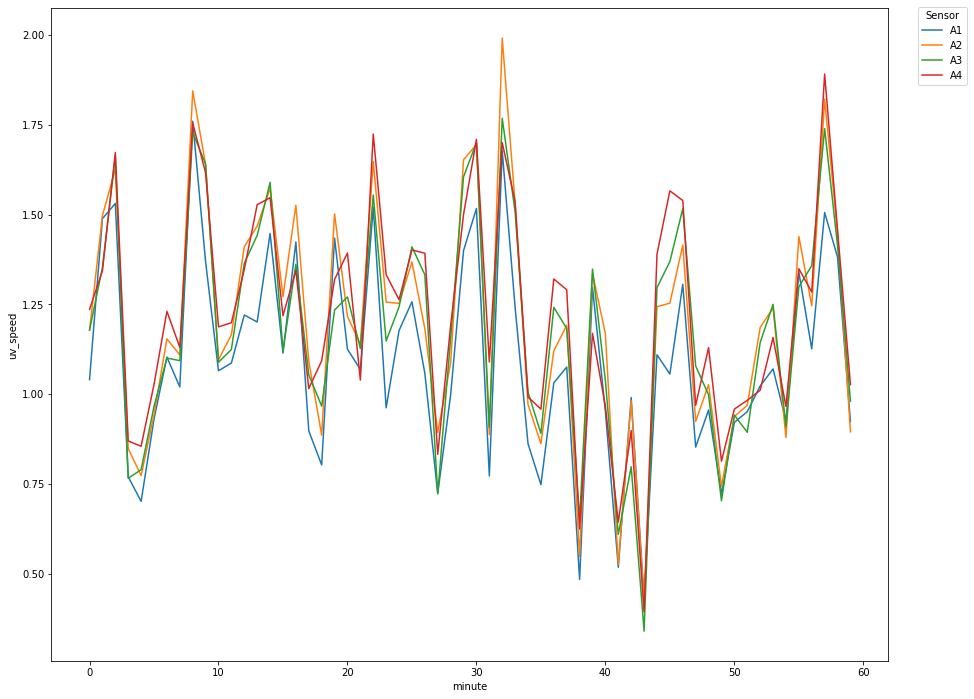

In [35]:
# select variable
var = 'uv_speed'
print(f'{var} Timeseries: {res} data')

# slice data
var_slice = ds[var].isel(dict(loc=sensor_indices))

# generate linear timeseries figure
fig, axs = plt.subplots(figsize=(15, 12))
f = xplt.line(var_slice, ax=axs, x=dim, add_legend=False)
axs.legend(handles=f, labels=list(var_slice.id.values), title='Sensor', loc='upper right', bbox_to_anchor=(1.1, 1.01))

line_colors = {}
for line_id, f_line in zip(var_slice.id.values, f):
    line_colors[line_id] = f_line.get_c()

### Timeseries of bearing

Bearing Timeseries: Minute-aggregated data


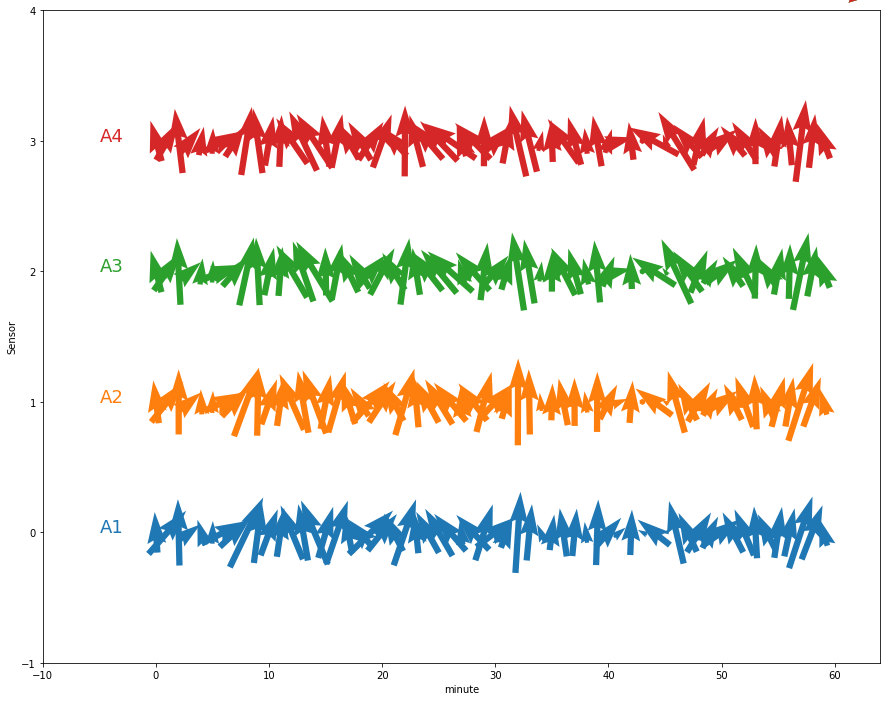

In [36]:
print(f'Bearing Timeseries: {res} data')

# slice data
var_slice = ds[var].isel(dict(loc=sensor_indices))
count = len(var_slice.id.values)
u_slice = ds['u'].isel(dict(loc=sensor_indices))
v_slice = ds['v'].isel(dict(loc=sensor_indices))

# set up figure configuration
ylim = [var_slice.min().values, var_slice.max().values]
axs_buffer = [5, 1]

# generate linear timeseries figure
fig, axs = plt.subplots(figsize=(15, 12))
axs.set_xlim([var_slice[dim][0] - 2 * axs_buffer[0], var_slice[dim][-1] + axs_buffer[0]])
axs.set_ylim([-axs_buffer[1], count + axs_buffer[1] - 1])
axs.set_ylabel('Sensor'); axs.set_xlabel(dim)

for idx in range(0, count):
    sid = list(var_slice.id.values)[idx]
    scol = line_colors[sid]
    Q = axs.quiver(var_slice[dim], np.full(var_slice[dim].shape[0], idx), u_slice.isel(loc=idx).values, v_slice.isel(loc=idx).values, 
                   pivot='mid', units='width', color=scol)
    qk = axs.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
    axs.text(var_slice[dim][0] - axs_buffer[0], idx, sid, color=scol, fontsize=18)


### Individual plots of speed + bearing / direction for single specified sensor

uv_speed + Bearing Timeseries for sensor A1: Minute-aggregated data


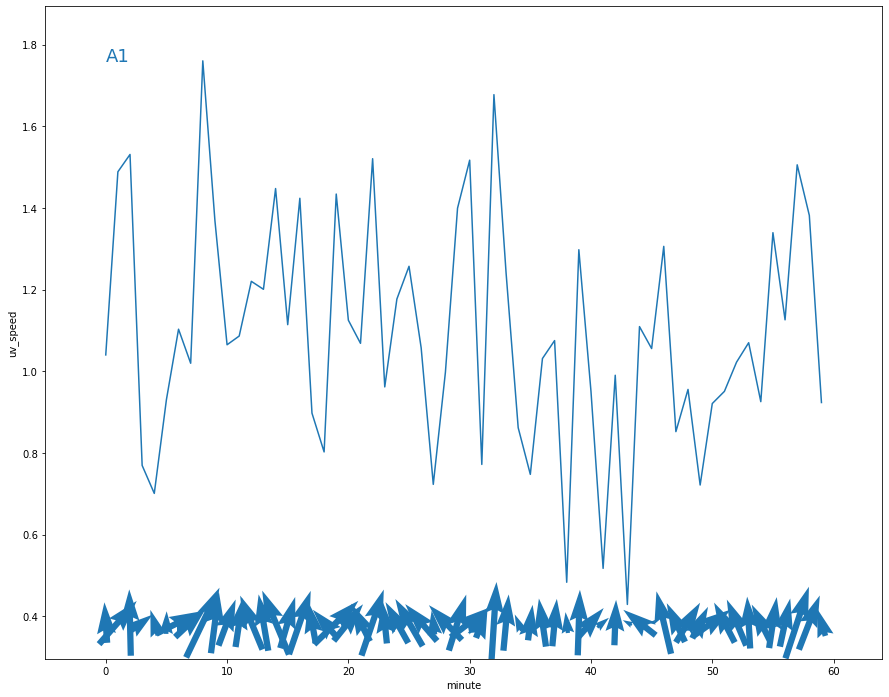

In [37]:
sid = 'A1'
sidx = get_id_indices(ds, [sid])[0]

# select variable
var = 'uv_speed'
print(f'{var} + Bearing Timeseries for sensor {sid}: {res} data')

# slice data
var_slice = ds[var].isel(dict(loc=sidx))
u_slice = ds['u'].isel(dict(loc=sidx))
v_slice = ds['v'].isel(dict(loc=sidx))
try:
    scol = line_colors[sid]
except:
    scol = 'black'

# set up figure configuration
ylim = [var_slice.min().values, var_slice.max().values]
axs_buffer = [5, 0.1]

# generate linear timeseries figure
fig, axs = plt.subplots(figsize=(15, 12))
axs.set_xlim([var_slice[dim][0] - axs_buffer[0], var_slice[dim][-1] + axs_buffer[0]])
axs.set_ylim([ylim[0] - axs_buffer[1] * (ylim[1]-ylim[0]), ylim[1] + axs_buffer[1] * (ylim[1]-ylim[0])])
axs.set_ylabel(var); axs.set_xlabel(dim)

axs.plot(var_slice[dim], var_slice.values)
Q = axs.quiver(var_slice[dim], np.full(var_slice[dim].shape[0], ylim[0] - axs_buffer[1]/3 * (ylim[1]-ylim[0])), u_slice.values, v_slice.values, 
               pivot='mid', units='width', color=scol)
qk = axs.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
t = axs.text(var_slice[dim][0], ylim[1], sid, color=scol, fontsize=18)